In [37]:
import json
import numpy as np

keypoints = [f"Point_{i}" for i in [0, 7, 11, 12, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]

# ✅ 1개 JSON 파일 → (1, T, 1, V, 3) 배열로 변환 + 정규화
def load_json_skeleton(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    num_frames = len(data["frames"])
    num_joints = len(keypoints)
    num_features = 3  # (x, y, z)
    num_views = 1

    # (1, T, 1, V, 3)
    X_data = np.zeros((1, num_frames, num_views, num_joints, num_features), dtype=np.float32)
    views = ["view4"]

    # 중심이동된 모든 xyz를 수집해서 정규화할 것
    all_xyz = []

    for frame_idx, frame in enumerate(data["frames"]):
        for view_idx, view in enumerate(views):
            pts = frame.get(view, {}).get("pts", {})

            # 기준점: Point_23 & Point_24 평균
            if "Point_23" in pts and "Point_24" in pts:
                cx = (pts["Point_23"]["x"] + pts["Point_24"]["x"]) / 2
                cy = (pts["Point_23"]["y"] + pts["Point_24"]["y"]) / 2
                cz = (pts["Point_23"]["z"] + pts["Point_24"]["z"]) / 2
            else:
                cx, cy, cz = 0, 0, 0

            for joint_idx, joint_name in enumerate(keypoints):
                if joint_name in pts:
                    x = pts[joint_name]["x"] - cx
                    y = pts[joint_name]["y"] - cy
                    z = pts[joint_name]["z"] - cz
                    X_data[0, frame_idx, view_idx, joint_idx] = [x, y, z]
                    all_xyz.append([x, y, z])

    # (N*T*V*J, 3)
    all_xyz = np.array(all_xyz)
    mean = all_xyz.mean()
    std = all_xyz.std()

    # 전체 평균 기준으로 z-score 정규화
    X_data = (X_data - mean) / std

    return X_data, data.get("type_info", None)


# ✅ 여러 JSON 파일 일괄 로드
def load_labeled_json_skeleton(file_paths, labels):
    X_data_list = []
    y_data_list = []

    for file_path, label in zip(file_paths, labels):
        X, _ = load_json_skeleton(file_path)
        X_data_list.append(X)
        y_data_list.append(label)

    X_train = np.concatenate(X_data_list, axis=0)  # (N, T, 1, V, 3)
    y_train = np.array(y_data_list)

    return X_train, y_train
    
# # ✅ JSON 데이터 로드 함수 (5개 각도 전처리)
# def load_json_skeleton(file_path):
#     with open(file_path, "r", encoding="utf-8") as f:
#         data = json.load(f)

#     num_frames = len(data["frames"])
#     num_joints = len(keypoints)
#     num_features = 2  # (x, y)
#     num_views = 1

#     # ✅ (1, 프레임, 뷰, 관절, 좌표) 형태로 데이터 배열 생성
#     X_data = np.zeros((1, num_frames, num_views, num_joints, num_features), dtype=np.float32)

#     views = ["view4"]

#     # ✅ JSON 데이터 -> 배열 변환
#     for frame_idx, frame in enumerate(data["frames"]):
#         for view_idx, view in enumerate(views):
#             pts = frame.get(view, {}).get("pts", {})
#             for joint_idx, joint_name in enumerate(keypoints):
#                 if joint_name in pts:
#                     X_data[0, frame_idx, view_idx, joint_idx, 0] = pts[joint_name]["x"]
#                     X_data[0, frame_idx, view_idx, joint_idx, 1] = pts[joint_name]["y"]

#     return X_data, data.get("type_info", None)

# # ✅ 여러 개의 JSON 파일을 한 번에 로드하는 함수 (올바른/잘못된 데이터 포함)
# def load_labeled_json_skeleton(file_paths, labels):
#     X_data_list = []
#     y_data_list = []

#     for file_path, label in zip(file_paths, labels):
#         X, _ = load_json_skeleton(file_path)
#         X_data_list.append(X)
#         y_data_list.append(label)

#     # ✅ 여러 개의 파일을 하나의 NumPy 배열로 병합
#     X_train = np.concatenate(X_data_list, axis=0)  # (batch_size, frames, views, joints, features)
#     y_train = np.array(y_data_list)                # (batch_size, )

#     return X_train, y_train
    
# ✅ 올바른 자세와 잘못된 자세 데이터를 함께 로드
file_paths = [
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-1-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-2-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-3-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-4-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-5-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-82.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-83.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-84.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-85.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-86.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-87.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-88.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-89.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-90.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-94.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-95.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-96.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-97.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-98.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-99.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-100.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-101.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-102.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-103.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-104.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-105.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-106.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-107.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-108.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-109.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-110.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-111.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-112.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-82.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-83.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-84.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-85.json",
]

labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1,]  # 0 = 올바른 자세, 1 = 잘못된 자세
    
# ✅ 올바른 자세와 잘못된 자세 데이터를 함께 로드
file_paths_val = [
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_16-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_14-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_01-1-94.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-82.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-83.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-84.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_02-1-85.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-86.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-87.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-88.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_04-1-89.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-90.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/R3/body_05-1-94.json",
]

labels_val = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1, 1, 1, 1,
]  # 0 = 올바른 자세, 1 = 잘못된 자세


# ✅ 전처리 실행
X_train, y_train = load_labeled_json_skeleton(file_paths, labels)
X_val, y_val = load_labeled_json_skeleton(file_paths_val, labels_val)
# ✅ 전처리된 데이터 형태 확인
print("전처리된 데이터 Shape:", X_train.shape)
print("전처리된 데이터 Shape:", X_val.shape)

전처리된 데이터 Shape: (70, 16, 1, 14, 2)
전처리된 데이터 Shape: (34, 16, 1, 14, 2)


In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import mediapipe as mp
from tensorflow.keras.callbacks import EarlyStopping

def jitter_data(data, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=data.shape)
    return data + noise

# ✅ Scaling (데이터 크기 변형)
def scale_data(data, scale_range=(0.9, 1.1)):
    scale = np.random.uniform(scale_range[0], scale_range[1], size=(data.shape[0], 1, 1, 1, 1))
    return data * scale  # ✅ 차원을 맞춰서 곱하기!

def rotate_skeleton(data, angle_range=(-5, 5)):
    angle = np.random.uniform(angle_range[0], angle_range[1]) * np.pi / 180  # 라디안 변환
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.dot(data, rotation_matrix)

# ✅ 인접 행렬 정규화 함수: self-loop 추가 및 D^(-1/2) A D^(-1/2) 적용
def normalize_adjacency_matrix(adj):
    # 자기 루프 추가
    np.fill_diagonal(adj, 1)
    # Degree matrix 계산
    degree = np.sum(adj, axis=1)
    # 0 나누기 방지
    degree[degree == 0] = 1
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degree))
    # 정규화된 인접 행렬 계산: D^(-1/2) A D^(-1/2)
    A_norm = D_inv_sqrt @ adj @ D_inv_sqrt
    return A_norm
    
# ✅ 그래프 컨볼루션 레이어 정의
class GraphConvLayer(layers.Layer):
    def __init__(self, units, adjacency_matrix_sport2):
        super(GraphConvLayer, self).__init__()
        self.units = units
        self.adjacency_matrix = tf.constant(adjacency_matrix_sport2, dtype=tf.float32)
        self.batch_norm = layers.BatchNormalization()  # 배치 정규화 추가

    def build(self, input_shape):
        # input_shape: (batch*frames, joints, features)
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        # inputs: (batch*frames, joints, features)
        x = tf.linalg.matmul(self.adjacency_matrix, inputs)  # Graph convolution
        x = tf.linalg.matmul(x, self.kernel)  # Apply learnable weights
        x = self.batch_norm(x)  # Batch normalization
        x = tf.nn.leaky_relu(x)  # Activation function applied AFTER batch norm
        return x

# ✅ ST-GCN 모델 정의
@tf.keras.utils.register_keras_serializable()
class STGCN_sport2(tf.keras.Model):
    def __init__(self, num_joints, num_features, adjacency_matrix_sport2, num_classes, **kwargs):
        super(STGCN_sport2, self).__init__(**kwargs)

        self.num_joints = num_joints
        self.num_features = num_features
        self.num_classes = num_classes
        self.adjacency_matrix_sport2 = tf.convert_to_tensor(adjacency_matrix_sport2, dtype=tf.float32)  # 텐서로 변환
        
        self.graph_conv1 = GraphConvLayer(64, adjacency_matrix_sport2)
        self.graph_conv2 = GraphConvLayer(128, adjacency_matrix_sport2)
        # self.graph_conv3 = GraphConvLayer(256, adjacency_matrix_sport2)  # 추가된 Graph Conv
        # self.graph_conv4 = GraphConvLayer(512, adjacency_matrix_sport2)  # 추가된 Graph Conv
        
        self.temporal_conv1 = layers.Conv1D(128, kernel_size=7, padding="same")
        self.temporal_conv2 = layers.Conv1D(64, kernel_size=7, padding="same")
        # self.temporal_conv3 = layers.Conv1D(128, kernel_size=5, padding="same")
        # self.temporal_conv4 = layers.Conv1D(64, kernel_size=3, padding="same")
        
        self.batch_norm1 = layers.BatchNormalization()
        self.batch_norm2 = layers.BatchNormalization()
        # self.batch_norm3 = layers.BatchNormalization()
        # self.batch_norm4 = layers.BatchNormalization()
        
        self.activation = layers.Activation("relu")
        self.global_pool = layers.GlobalAveragePooling1D()
        self.fc = layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.dropout = layers.Dropout(0.3) 

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        # ✅ 입력 처리: (batch, frames, views, joints, features)
        if len(inputs.shape) == 5:
            # 여러 각도(View) 데이터가 있는 경우 평균 내기
            inputs = tf.reduce_mean(inputs, axis=2)  # (batch, frames, joints, features)
        
        batch_size = tf.shape(inputs)[0]
        frames = tf.shape(inputs)[1]
        joints = tf.shape(inputs)[2]
        features = tf.shape(inputs)[3]
        x = tf.reshape(inputs, (batch_size * frames, joints, features))  # (batch * joints, frames, features)
        
        # ✅ 모델 처리
        x = self.graph_conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = self.graph_conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)

        # x = self.graph_conv3(x)
        # x = self.batch_norm3(x)
        # x = self.activation(x)

        # x = self.graph_conv4(x)
        # x = self.batch_norm4(x)
        # x = self.activation(x)

        # Temporal Conv를 위해 프레임별로 모든 관절의 정보를 하나의 벡터로 결합
        out_features = tf.shape(x)[-1]
        x = tf.reshape(x, (batch_size, frames, joints * out_features))

        x = self.temporal_conv1(x)
        x = self.temporal_conv2(x)
        # x = self.temporal_conv3(x)
        # x = self.temporal_conv4(x)

        # frames 차원을 평균 내어 최종 특징 벡터 생성
        x = self.global_pool(x)
        x = self.dropout(x)
        
        return self.fc(x)

    def get_config(self):
        config = super(STGCN_sport2, self).get_config()
        config.update({
            "num_joints": self.num_joints,
            "num_features": self.num_features,
            "adjacency_matrix_sport2": self.adjacency_matrix_sport2.numpy().tolist(), 
            "num_classes": self.num_classes,
            "name": self.name  # 
        })
        return config

    @classmethod
    def from_config(cls, config):
        import numpy as np
        config["adjacency_matrix_sport2"] = np.array(config["adjacency_matrix_sport2"])  # 리스트를 numpy 배열로 변환
        return cls(**config)

# Mediapipe에서 제공하는 POSE_CONNECTIONS을 활용
mp_pose = mp.solutions.pose
connections = list(mp_pose.POSE_CONNECTIONS)

selected_joints = [0, 7, 11, 12, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

# ✅ 원본 33개 관절을 기반으로 한 인접 행렬 생성
full_adjacency_matrix = np.zeros((33, 33))  # 전체 33개 관절을 사용한 경우
for joint1, joint2 in connections:
    full_adjacency_matrix[joint1, joint2] = 1
    full_adjacency_matrix[joint2, joint1] = 1  # 대칭 관계

# ✅ 선택된 관절만을 포함하는 인접 행렬 생성
num_joints = len(selected_joints)
adjacency_matrix_sport2 = np.zeros((num_joints, num_joints))

for i, joint1 in enumerate(selected_joints):
    for j, joint2 in enumerate(selected_joints):
        adjacency_matrix_sport2[i, j] = full_adjacency_matrix[joint1, joint2]  # 기존 인접 행렬에서 추출

# 인접 행렬 정규화 (자기 루프 추가 및 정규화)
adjacency_matrix_norm = normalize_adjacency_matrix(adjacency_matrix_sport2)
print(f"Normalized adjacency matrix shape: {adjacency_matrix_norm.shape}")

num_features = 2
num_classes = 2  # (올바른 자세 / 잘못된 자세)

# ✅ ST-GCN 모델 생성 및 컴파일
# del stgcn_model_sport2
stgcn_model_sport2 = STGCN_sport2(num_joints, num_features, adjacency_matrix_norm, num_classes)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=6000,
    alpha=0.001
)

stgcn_model_sport2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 2️⃣ Train 데이터에만 데이터 증강 적용
X_train_augmented = jitter_data(X_train)
X_train_augmented = scale_data(X_train_augmented)
X_train_augmented = rotate_skeleton(X_train_augmented)

# 3️⃣ 원본 데이터 + 증강 데이터 함께 사용
X_train = np.concatenate([X_train, X_train_augmented])
y_train = np.concatenate([y_train, y_train])  # 증강된 데이터는 같은 레이블 사용

# Ensure y_val is also categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ✅ 클래스 비율 확인
unique, counts = np.unique(y_train, return_counts=True)
print(f"📊 클래스별 샘플 개수: {dict(zip(unique, counts))}")

# ✅ 정규화된 값 확인
print(f"X_train min after scaling: {np.min(X_train)}")
print(f"X_train max after scaling: {np.max(X_train)}")
print(f"X_train mean after scaling: {np.mean(X_train)}")
print(f"X_train std after scaling: {np.std(X_train)}")

# ✅ Train the model
history = stgcn_model_sport2.fit(
    X_train, y_train, 
    epochs=500, batch_size=32, verbose=1, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

# 학습 횟수 확인
print(f"Before saving: optimizer steps = {stgcn_model_sport2.optimizer.iterations.numpy()}")

stgcn_model_sport2.save("stgcn_model_sport2_1.keras")

Normalized adjacency matrix shape: (14, 14)
📊 클래스별 샘플 개수: {0.0: 140, 1.0: 140}
X_train min after scaling: 0.1443914120219858
X_train max after scaling: 0.9361411423540241
X_train mean after scaling: 0.574733748095631
X_train std after scaling: 0.13718400336321365
Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5026 - loss: 1.7876 - val_accuracy: 0.5000 - val_loss: 0.9529
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4558 - loss: 1.0159 - val_accuracy: 0.5000 - val_loss: 0.7810
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4870 - loss: 0.7679 - val_accuracy: 0.5000 - val_loss: 0.7854
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4430 - loss: 0.7857 - val_accuracy: 0.5000 - val_loss: 0.7386
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4991 - loss: 0.7384 - val_accuracy: 0.5000 - val_loss: 0.7367
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5421 - loss: 0.7355 - val_accuracy: 0.5000

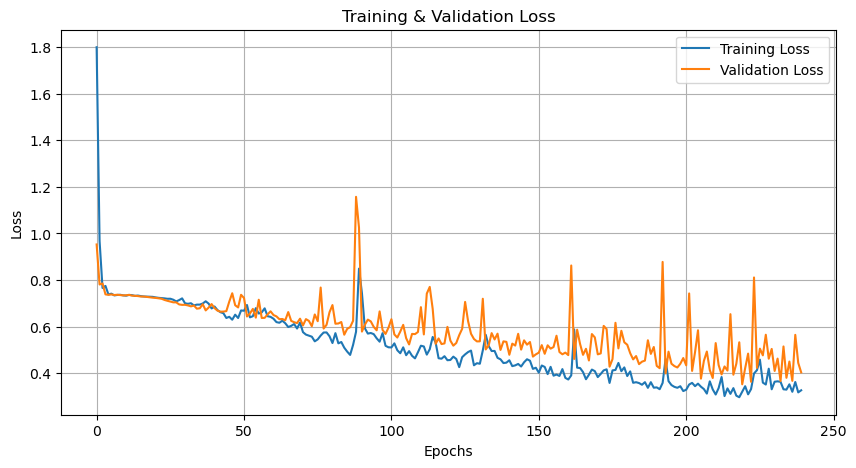

In [39]:
import matplotlib.pyplot as plt

# ✅ Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [40]:
from tensorflow.keras.models import load_model

def predict_multiple_json_skeleton(file_paths):
    results = {}


    for file_path in file_paths:
        try:
            # ✅ JSON 데이터 로드
            X_data, _ = load_json_skeleton(file_path)

            # ✅ 모델 예측
            prediction = stgcn_model_sport2.predict(X_data)
            
            # ✅ 예측 결과 처리
            predicted_class = np.argmax(prediction, axis=-1)[0]
            confidence = prediction[0][predicted_class]

            # ✅ 결과 저장
            if predicted_class == 0:
                results[file_path] = f"✅ 올바른 자세 ({confidence * 100:.2f}% 확신)"
            else:
                results[file_path] = f"❌ 잘못된 자세 감지 ({confidence * 100:.2f}% 확신)"

        except Exception as e:
            results[file_path] = f"❌ 예측 실패 (오류: {e})"

    return results



# ✅ 여러 개의 JSON 파일 리스트
file_paths = [
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-94.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-82.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-83.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-84.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-85.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-86.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-87.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-88.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-89.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-90.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-94.json",
    
]

# ✅ 예측 결과 얻기
prediction_results = predict_multiple_json_skeleton(file_paths)

# ✅ 결과 출력
for file, result in prediction_results.items():
    print(f"{file}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [41]:
stgcn_model_sport2.summary()
model = load_model(
    "stgcn_model_sport2_1.keras", 
    custom_objects={
        "STGCN_sport2": STGCN_sport2,
        "GraphConvLayer": GraphConvLayer
    }
)

model.summary()

Model: "stgcn_sport2_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ graph_conv_layer_6 (GraphConvLayer)  │ ?                           │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv_layer_7 (GraphConvLayer)  │ ?                           │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 16, 128)             │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 16, 64)              │          57,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 14, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 14, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,017,928 (19.14 MB)

 Trainable params: 1,672,386 (6.38 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 3,344,774 (12.76 MB)

Model: "stgcn_sport2_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ graph_conv_layer_8 (GraphConvLayer)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv_layer_9 (GraphConvLayer)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (12.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [65]:
# 더미 입력 생성 (batch=1, frames=16, views=1, joints=14, features=2)
dummy_input = np.zeros((1, 16, 1, 14, 2), dtype=np.float32)

# 예측 → 내부 call() 실행 → 레이어 자동 빌드
model.predict(dummy_input)

# summary 확인
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


Model: "stgcn_sport2_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ graph_conv_layer_8 (GraphConvLayer)  │ ?                           │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv_layer_9 (GraphConvLayer)  │ ?                           │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (1, 16, 128)                │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (1, 16, 64)                 │          57,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (16, 14, 64)                │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (16, 14, 128)               │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (1, 2)                      │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,673,156 (6.38 MB)

 Trainable params: 1,672,386 (6.38 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [77]:
# 옵티마이저 상태 변수 저장
optimizer_weights = [var.numpy() for var in stgcn_model_sport2.optimizer.variables]

# numpy 배열 리스트를 저장
import pickle
with open("optimizer_weights.pkl", "wb") as f:
    pickle.dump(optimizer_weights, f)

# 모델 자체는 weights만 저장
stgcn_model_sport2.save_weights("stgcn_model_sport2_1.weights.h5")


In [79]:
model = STGCN_sport2(num_joints, num_features, adjacency_matrix_norm, num_classes)

dummy_input = np.random.rand(1, 10, num_joints, num_features).astype(np.float32)
model(dummy_input)

model.load_weights("stgcn_model_sport2_1.weights.h5")

In [81]:
from tensorflow.keras.models import load_model

def predict_multiple_json_skeleton(file_paths):
    results = {}


    for file_path in file_paths:
        try:
            # ✅ JSON 데이터 로드
            X_data, _ = load_json_skeleton(file_path)

            # ✅ 모델 예측
            prediction = model.predict(X_data)
            
            # ✅ 예측 결과 처리
            predicted_class = np.argmax(prediction, axis=-1)[0]
            confidence = prediction[0][predicted_class]

            # ✅ 결과 저장
            if predicted_class == 0:
                results[file_path] = f"✅ 올바른 자세 ({confidence * 100:.2f}% 확신)"
            else:
                results[file_path] = f"❌ 잘못된 자세 감지 ({confidence * 100:.2f}% 확신)"

        except Exception as e:
            results[file_path] = f"❌ 예측 실패 (오류: {e})"

    return results



# ✅ 여러 개의 JSON 파일 리스트
file_paths = [
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-8-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-9-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_16-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_14-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-7-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-6-81.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_01-1-94.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-82.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-83.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-84.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_02-1-85.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-86.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-87.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-88.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_04-1-89.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-90.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-91.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-92.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-93.json",
    "D:/Studying/gradu/013.피트니스자세/1.Training/sport2/body_05-1-94.json",
    
]

# ✅ 예측 결과 얻기
prediction_results = predict_multiple_json_skeleton(file_paths)

# ✅ 결과 출력
for file, result in prediction_results.items():
    print(f"{file}: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [83]:
np.save("adjacency_matrix_sport2.npy", adjacency_matrix_norm)